# PortfolioTimeSeries

## Preliminaries
This code builds time-series portfolio strategies.\
The data can be found in the *DATA* folder.\
For this strategy, we only use `ETFdata.parquet`.

We first load several packages to initialize Python.






In [3]:
import statsmodels.formula.api as sm
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import wrds 
import qpm
import qpm_download

pd.options.mode.chained_assignment = None

Select wether you would like to download data directly from WRDS (import_data = True) or to load data from Dropbpx (import_data = False). If you decide to load data from Dropbox, make sure to define the data directoy (_DATA_DIR).

In [5]:
import_data = False             # <-- Edit this line
_DATA_DIR = '/Users/jiahongcai/Desktop/Quantitative Strategies/Data/ETFData.parquet'  

We can select the sample period and ticker here. We can select an ETF covering the financial sector (ticker: XLF) or the S&P500 (ticker: SPY). 

However, we can adjust this to any ticker. The file *ETFdata.parquet* contains thousands of ETFs. These ETFs allow exploration on multiple assets classes, industries or countries.

In [6]:
# Select the sample period
_SAMPLE_START = '2005-01-01'
_SAMPLE_END = '2023-07-31'

# Select the ticker
_ETF_TICKER = 'SPY'

## Step 1.  Load Data
We first load the *daily* ETF data and we store it in df_ETF. 

In [7]:
if import_data == True: 
    
    df_ETF_raw = qpm_download.time_series(_SAMPLE_START, _SAMPLE_END)
        
if import_data == False:
    
    # Load the data
    df_ETF_raw = pd.read_parquet(_DATA_DIR)

For each ETF, we have the daily return, retd, and the return of that month, retM. We use the daily return to compute the standard deviation below. The variable date is the daily date; the variable ym is the year and month.

The factors (mktrf = excess return on the market, smb = the Fama and French size factor, hml = the Fama and French value factor, rf = the risk-free rate, umd = the momentum factor) are all monthly variables. In the dataset available in Dropbox, we also include the CPI, inflation, and yr5breakeven, which is the 5-year break-even inflation rate. We include those to explore strategies related to inflation risk, which is an important theme in the industry at the moment. We drop these data for this problem set as we don't need them.

In [8]:
# Select the ETF using the ticker symbol
df_ETF = df_ETF_raw[df_ETF_raw['ticker'] == _ETF_TICKER]

# Select the relevant variables for our strategy
df_ETF = df_ETF[['date', 'ym', 'retd', 'retM', 'mktrf', 'rf']]

# Sort the data
df_ETF.sort_values(['date'], inplace = True)

# Print the data 
df_ETF

,date,ym,retd,retM,mktrf,rf
16,2003-01-02,2003-01-01,0.032189,-0.024595,-0.0257,0.0010
180,2003-01-03,2003-01-01,0.003075,-0.024595,-0.0257,0.0010
293,2003-01-06,2003-01-01,0.017625,-0.024595,-0.0257,0.0010
519,2003-01-07,2003-01-01,-0.002474,-0.024595,-0.0257,0.0010
525,2003-01-08,2003-01-01,-0.014451,-0.024595,-0.0257,0.0010
...,...,...,...,...,...,...
6664515,2023-07-25,2023-07-01,0.002730,0.032733,0.0321,0.0045
6667593,2023-07-26,2023-07-01,0.000154,0.032733,0.0321,0.0045
6671234,2023-07-27,2023-07-01,-0.006630,0.032733,0.0321,0.0045
6672516,2023-07-28,2023-07-01,0.009790,0.032733,0.0321,0.0045


## Step 2. Portfolio Construction
To compute the standard deviation, we first group the data by month.

In [9]:
grouped = df_ETF.groupby('ym')

Next, we compute the statistic we need per month for each variable. For the daily returns, we need the standard deviation. For the monthly returns, we just pick the first observation (as those variables are constant within a given month). The following code then computes these statistics and provides a dataset that has one observation per month. We call the standard deviation of daily returns sd.

In [10]:
df = grouped.agg({
    'retd': 'std',
    'retM': 'first',
    'rf': 'first',
    'mktrf': 'first'
})
df = df.rename(columns={'retd': 'sd'})
df

,sd,retM,rf,mktrf
ym,,,,
2003-01-01,0.014982,-0.024595,0.0010,-0.0257
2003-02-01,0.011635,-0.013479,0.0009,-0.0188
2003-03-01,0.016972,0.002289,0.0010,0.0109
2003-04-01,0.011782,0.084612,0.0010,0.0822
2003-05-01,0.009799,0.054836,0.0009,0.0605
...,...,...,...,...
2023-03-01,0.011428,0.036936,0.0036,0.0251
2023-04-01,0.007591,0.015975,0.0035,0.0061
2023-05-01,0.008056,0.004616,0.0036,0.0035


We can only form portfolios based on information that we know in advance. For instance, for the portfolio that we hold in October 2023, we can only use data that we know in September 2023. We therefore lag the volatility signal by one period.\
We compute the lag using *shift*. We then annualize the standard deviation by the square root of the number of trading days, $\sqrt{252}$

In [11]:
df['Lsd'] = df['sd'].shift(1) * np.sqrt(252)
df

,sd,retM,rf,mktrf,Lsd
ym,,,,,
2003-01-01,0.014982,-0.024595,0.0010,-0.0257,NaN
2003-02-01,0.011635,-0.013479,0.0009,-0.0188,0.237840
2003-03-01,0.016972,0.002289,0.0010,0.0109,0.184698
2003-04-01,0.011782,0.084612,0.0010,0.0822,0.269417
2003-05-01,0.009799,0.054836,0.0009,0.0605,0.187029
...,...,...,...,...,...
2023-03-01,0.011428,0.036936,0.0036,0.0251,0.155672
2023-04-01,0.007591,0.015975,0.0035,0.0061,0.181410
2023-05-01,0.008056,0.004616,0.0036,0.0035,0.120508


There is one missing value created, but we will take care of this in constructing the portfolio weights.

We are now ready to compute the portfolio weight as
$$w(t) = \min\left\{\frac{c}{\sigma_t},2\right\},$$
where $c$ is a scaling factor. It determines the amount of risk we'd like to take. Higher values of $c$ correspond to riskier strategies. We want to have an average $\beta$ of about 1. We choose $c=1.25 \times \overline{\sigma_t}$, where $\overline{\sigma_t}$ is the average volatility, $\sigma_t$. We take 1.25 so that the average $\beta$ is around one. We take the minimum of $\frac{c}{\sigma_t}$ and 2 to avoid that the portfolio gets too extreme during low volatility periods. 

The code has three steps
1. Compute the scaling $c$.
2. Compute the portfolio weight. Note that in computing the portfolio weight, it ends with `fillna(1)`. This means that missing portfolio weights (caused by the missing value of the standard deviation above) are replaced with 1, that is, invest all capital in the ETF.
3. In the final step, we drop the data from the standard deviation (`sd`), the lagged standard deviation (`Lsd`) and the scaling factor (`c`), as we no longer need those for the remainder of the code.

In [12]:
df['c'] = 1.25 * df['Lsd'].mean()
df['weight'] = np.minimum(df['c'] / df['Lsd'], 2).fillna(1)
df.drop(columns = ['sd','Lsd', 'c'], inplace = True)
df

,retM,rf,mktrf,weight
ym,,,,
2003-01-01,-0.024595,0.0010,-0.0257,1.000000
2003-02-01,-0.013479,0.0009,-0.0188,0.824854
2003-03-01,0.002289,0.0010,0.0109,1.062179
2003-04-01,0.084612,0.0010,0.0822,0.728175
2003-05-01,0.054836,0.0009,0.0605,1.048943
...,...,...,...,...
2023-03-01,0.036936,0.0036,0.0251,1.260228
2023-04-01,0.015975,0.0035,0.0061,1.081431
2023-05-01,0.004616,0.0036,0.0035,1.627962


We can now compute the return on the portfolio
$$r_p(t) = w(t) r_{ETF}(t)+[1-w(t)]r_f(t).$$
The first line computes the raw return, and the next two lines compute the excess return by subtracting the risk-free rate.

In [13]:
# Returns on the volatility timing strategy
df['retP'] = df['weight'] * df['retM'] + (1 - df['weight']) * df['rf']

# Excess returns on the volatility timing strategy
df['reteP'] = df['retP'] - df['rf']

# Excess returns on the ETF itself (without volatility timing)
df['reteM'] = df['retM'] - df['rf']

# Drop the risk-free rate from the data as we no longer need it
df.drop(columns = ['rf'], inplace = True)

df

,retM,mktrf,weight,retP,reteP,reteM
ym,,,,,,
2003-01-01,-0.024595,-0.0257,1.000000,-0.024595,-0.025595,-0.025595
2003-02-01,-0.013479,-0.0188,0.824854,-0.010961,-0.011861,-0.014379
2003-03-01,0.002289,0.0109,1.062179,0.002370,0.001370,0.001289
2003-04-01,0.084612,0.0822,0.728175,0.061884,0.060884,0.083612
2003-05-01,0.054836,0.0605,1.048943,0.057476,0.056576,0.053936
...,...,...,...,...,...,...
2023-03-01,0.036936,0.0251,1.260228,0.045611,0.042011,0.033336
2023-04-01,0.015975,0.0061,1.081431,0.016991,0.013491,0.012475
2023-05-01,0.004616,0.0035,1.627962,0.005254,0.001654,0.001016


## Step 3. Portfolio Analytics
We first select the sample period that we would like to study.

In [14]:
df = df[(df.index >= _SAMPLE_START) & (df.index <= _SAMPLE_END)]
df

,retM,mktrf,weight,retP,reteP,reteM
ym,,,,,,
2005-01-01,-0.022421,-0.0276,2.000000,-0.046442,-0.048042,-0.024021
2005-02-01,0.020904,0.0189,1.954202,0.039324,0.037724,0.019304
2005-03-01,-0.018262,-0.0197,1.817270,-0.034903,-0.037003,-0.020362
2005-04-01,-0.018735,-0.0261,1.868233,-0.036825,-0.038925,-0.020835
2005-05-01,0.032225,0.0365,1.279796,0.040569,0.038169,0.029825
...,...,...,...,...,...,...
2023-03-01,0.036936,0.0251,1.260228,0.045611,0.042011,0.033336
2023-04-01,0.015975,0.0061,1.081431,0.016991,0.013491,0.012475
2023-05-01,0.004616,0.0035,1.627962,0.005254,0.001654,0.001016


Let's plot the portfolio weights to see what the strategy does.

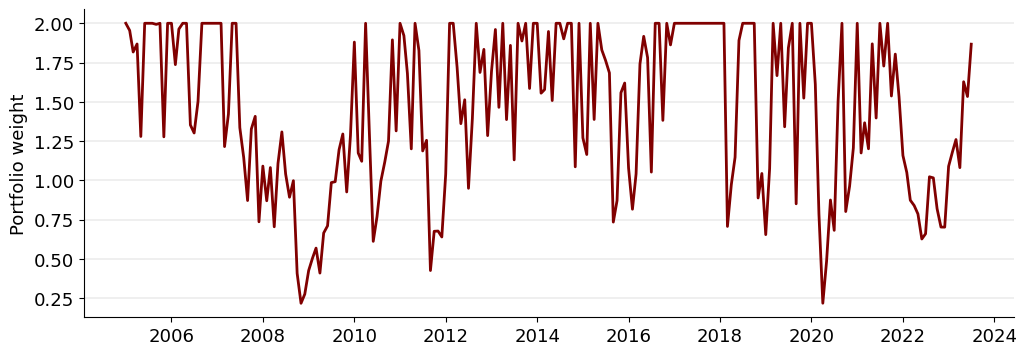

In [15]:
fig, ax = plt.subplots()
ax.plot(df.index, df['weight'], linewidth=2.0)
plt.ylabel('Date')
plt.ylabel('Portfolio weight')
plt.show()

Plot cumulative returns:

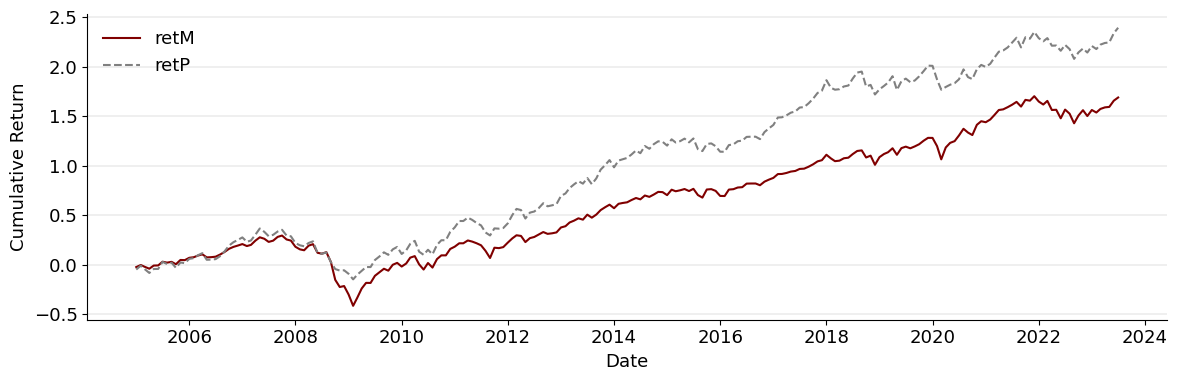

In [16]:
qpm.plot_cumulative_returns_etf(df, var_list = ['retM', 'retP'])

The next block computes the annualized average return, the standard deviation, and Sharpe ratio for each of the strategies.

In [17]:
# Compute summary statistics, and only keep the mean and the standard deviation
summary = df[['reteM', 'reteP']].describe().T[['mean', 'std']]

# Annualize the mean
summary['mean'] = summary['mean'] * 12

# Annualize the standard deviation
summary['std'] = summary['std'] * np.sqrt(12)

# Compute the Sharpe ratio
summary['sr'] = summary['mean'] / summary['std']

# Print the mean, standard deviation, and Sharpe ratio
print(summary.round(3))

        mean    std     sr
reteM  0.090  0.151  0.595
reteP  0.132  0.174  0.757


Now let's see whether the strategy using `SPY` generates alpha. We use the market excess return as our benchmark. You can change the end of the sample by modifying the date `2019-12-01`. In the first case, we stop before 2020.

In [18]:
# Select the sample
reg_df_select = df[df.index <= '2019-12-01']

# Run a regression of reteP (the excess return on the vol timed strategy) on the excess return of the market
result = sm.ols('reteP ~ mktrf', data=reg_df_select).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  reteP   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     666.7
Date:                Sat, 18 Nov 2023   Prob (F-statistic):           4.33e-62
Time:                        21:30:38   Log-Likelihood:                 432.38
No. Observations:                 180   AIC:                            -860.8
Df Residuals:                     178   BIC:                            -854.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0039      0.002      2.354      0.0